In [1]:
# ========================================================================
#                     Time Series Analysis Project
# ========================================================================
#    Project: Surface Air Temperature Mean Daily Minimum
#    Model: Long Short-Term Memory (LSTM) Implementation
#    
#    Description:
#    Advanced time series analysis using LSTM neural networks for temperature
#    prediction. This implementation is part of a series exploring sequential
#    models from SimpleRNN to Transformers.
#    
#    Author: Dr. Saad Laouadi
#    Date: February 2025
#    Version: 1.0
#    
# ========================================================================
#  ®Copyright Dr. Saad Laouadi, 2025. All rights reserved.
# ========================================================================

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

print("*"*52)
%reload_ext watermark

%watermark -a "Dr. Saad Laouadi"
%watermark -iv -ud
print("*"*52)

****************************************************
Author: Dr. Saad Laouadi

Last updated: 2025-02-22

pandas    : 2.2.2
matplotlib: 3.9.2
sklearn   : 1.5.1
tensorflow: 2.16.2
numpy     : 1.26.4

****************************************************


In [3]:
# =============================================================== #
#        User Defined Functions
# =============================================================== #

def load_data(filepath):
    """
    Load and preprocess the temperature data.
    """
    df = pd.read_csv(filepath)
    
    # Convert month column to datetime
    df['month'] = pd.to_datetime(df['month'], format='%Y-%m')
    
    # Set month as index
    df.set_index('month', inplace=True)
    
    return df


def create_sequences(data, lookback):
    """Create sequences for LSTM model."""
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback)])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)


def split_data(data, train_size=0.8):
    """Split data into training and testing sets."""
    n = len(data)
    train_size = int(n * train_size)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data


def normalize_data(train_data, test_data):
    """Normalize data using MinMaxScaler."""
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))
    return train_scaled, test_scaled, scaler


def build_lstm_model(lookback):
    """Build an LSTM model.
    
    Key differences from SimpleRNN:
    - Uses LSTM layer instead of SimpleRNN
    - LSTM maintains cell state for better long-term memory
    - Has forget, input, and output gates
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(lookback, 1)),
        tf.keras.layers.LSTM(50, activation='tanh',
                           dropout=0.2,
                           recurrent_dropout=0.2),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer='adam',
                 loss='mse',
                 metrics=[tf.keras.metrics.RootMeanSquaredError(),
                         tf.keras.metrics.MeanAbsoluteError()])
    return model


def train_model(model, X_train, y_train, epochs=500, batch_size=32):
    """Train the LSTM model."""
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30
    )
    
    history = model.fit(X_train, y_train,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_split=0.2,
                       callbacks=[callback],
                       verbose=1)
    return history


def plot_training_history(history):
    """Plot training history."""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    
def plot_predictions(actual, predictions, title):
    """Plot actual vs predicted values."""
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()

    
def evaluate_model(model, X_test, y_test, scaler):
    """Evaluate the LSTM model performance."""
    # Make predictions
    predictions = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    predictions = scaler.inverse_transform(predictions)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Initialize metrics
    mse_metric = tf.keras.metrics.MeanSquaredError()
    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    
    # Update metrics state
    mse_metric.update_state(y_test_inv, predictions)
    rmse_metric.update_state(y_test_inv, predictions)
    mae_metric.update_state(y_test_inv, predictions)
    
    # Calculate final metrics
    mse = mse_metric.result().numpy()
    rmse = rmse_metric.result().numpy()
    mae = mae_metric.result().numpy()
    
    metrics = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae
    }
    print(f'Test MSE:  {mse:.4f}')
    print(f'Test RMSE: {rmse:.4f}')
    print(f'Test MAE:  {mae:.4f}')
    
    return predictions, y_test_inv, metrics

In [4]:
# Main execution
# =============
# Load data
data_path = "../../datasets/SurfaceAirTemperatureMonthlyMeanDailyMinimum.csv"
df = load_data(data_path)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 517 entries, 1982-01-01 to 2025-01-01
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temp_mean_daily_min  517 non-null    float64
dtypes: float64(1)
memory usage: 8.1 KB
None


,temp_mean_daily_min
month,
1982-01-01,23.3
1982-02-01,23.9
1982-03-01,24.3
1982-04-01,24.3
1982-05-01,25.2


In [5]:
# print the data index
print(df.index)

DatetimeIndex(['1982-01-01', '1982-02-01', '1982-03-01', '1982-04-01',
               '1982-05-01', '1982-06-01', '1982-07-01', '1982-08-01',
               '1982-09-01', '1982-10-01',
               ...
               '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01',
               '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01',
               '2024-12-01', '2025-01-01'],
              dtype='datetime64[ns]', name='month', length=517, freq=None)


In [6]:
# get air-temperature data
temperature_data = df['temp_mean_daily_min'].values 

In [7]:
# Split data
train_data, test_data = split_data(temperature_data)

In [8]:
# Normalize data after splitting
train_scaled, test_scaled, scaler = normalize_data(train_data, test_data)

In [9]:
# Create sequences
lookback = 12  # Use 12 months for prediction
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(401, 12, 1)
(92, 12, 1)
(401, 1)
(92, 1)


In [10]:
# Build and train model
model = build_lstm_model(lookback)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = train_model(model, X_train, y_train)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.1763 - mean_absolute_error: 0.3736 - root_mean_squared_error: 0.4186 - val_loss: 0.0588 - val_mean_absolute_error: 0.1934 - val_root_mean_squared_error: 0.2425
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0708 - mean_absolute_error: 0.2118 - root_mean_squared_error: 0.2661 - val_loss: 0.0293 - val_mean_absolute_error: 0.1433 - val_root_mean_squared_error: 0.1711
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0542 - mean_absolute_error: 0.1887 - root_mean_squared_error: 0.2328 - val_loss: 0.0467 - val_mean_absolute_error: 0.1710 - val_root_mean_squared_error: 0.2161
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0596 - mean_absolute_error: 0.1898 - root_mean_squared_error: 0.2435 - val_loss: 0.0438 - val_mean_absolute_error: 0.1662 - val_root_mean_squared_error: 0.2093
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0441 - mean_absolute_error: 0.1663 - root_mean_squ

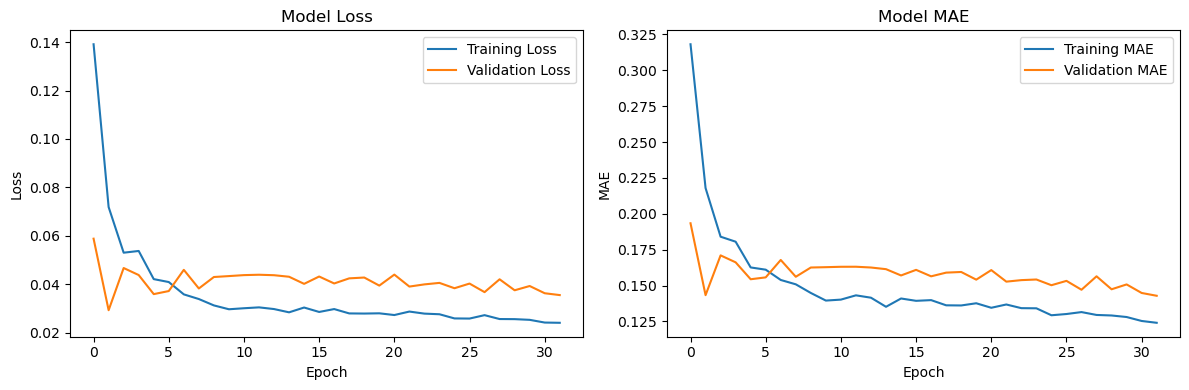

In [12]:
# Plot training history
plot_training_history(history)

In [13]:
# Make predictions and evaluate on train data
train_pred, y_train_inv, train_metrics = evaluate_model(model, X_train, y_train, scaler)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Test MSE:  0.3636
Test RMSE: 0.6030
Test MAE:  0.4743


In [14]:
# Make predictions and evaluate on test data
test_pred, y_test_inv, test_metrics = evaluate_model(model, X_test, y_test, scaler)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test MSE:  0.7800
Test RMSE: 0.8832
Test MAE:  0.7314


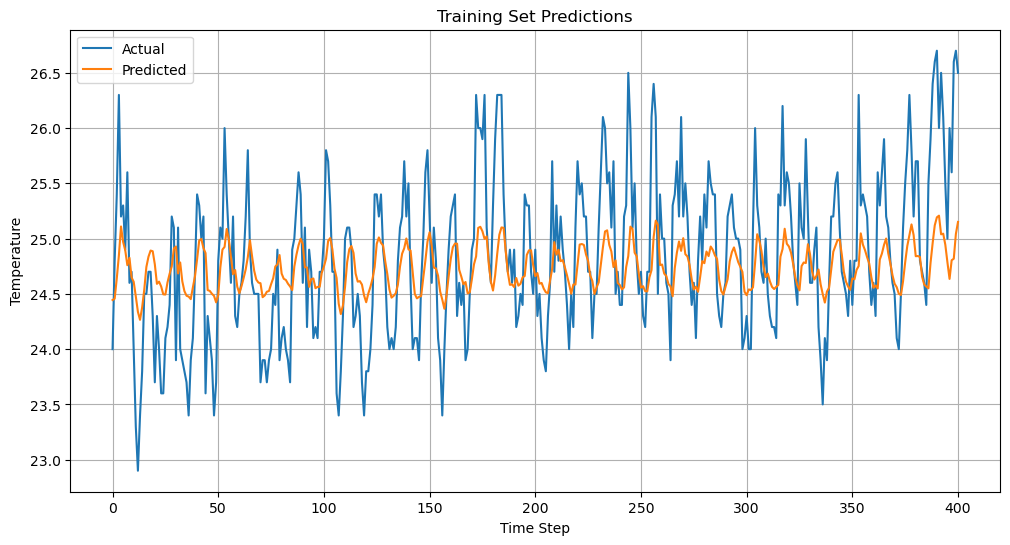

In [15]:
# Plot the taining results
plot_predictions(y_train_inv, train_pred, 'Training Set Predictions')

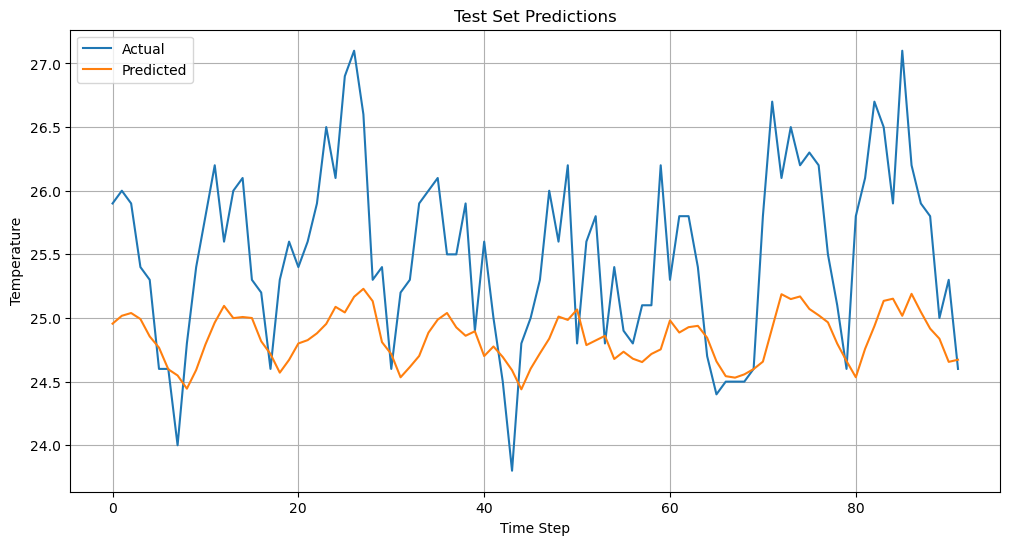

In [16]:
plot_predictions(y_test_inv, test_pred, 'Test Set Predictions')

In [17]:
# train metrics
pd.DataFrame([train_metrics])

,mse,rmse,mae
0,0.363631,0.603018,0.474305


In [18]:
# test metrics
pd.DataFrame([test_metrics])

,mse,rmse,mae
0,0.780024,0.883189,0.73143
